# セットアップ

In [1]:
# PyTorchバージョン変更
! pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# github からコードをコピー
! git clone -b feature/maskdetection https://github.com/tasotasoso/pytorch_ssd.git
%cd pytorch_ssd

# 学習済みパラメータをダウンロード
! wget -P weights https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 703.8 MB 23 kB/s 
     |████████████████████████████████| 6.6 MB 66.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.5.0+cu101 which is incompatible.
Cloning into 'pytorch_ssd'...
remote: Enumerating objects: 2594, done.
remote: Counting objects: 100% (876/876), done.
remote: Compressing objects: 100% (458/458), done.
remote: Total 259

In [2]:
# GPUの種類確認
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-bb0c08dd-2272-f444-da53-1e14ef070771)


# 学習済みモデルによる物体検出（VOCクラス）

Loading weights into state dict...
Finished!


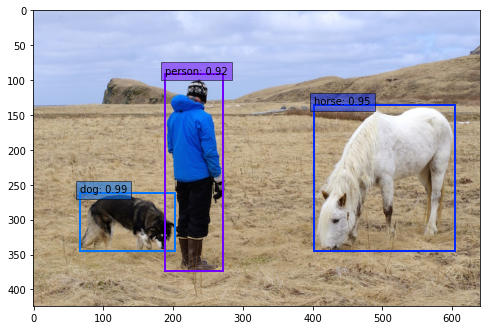

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
 
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import cv2
from ssd import build_ssd
from matplotlib import pyplot as plt
from data import VOC_CLASSES as voc_labels
from tqdm import tqdm_notebook as tqdm

# GPUの設定
torch.cuda.is_available() 
torch.set_default_tensor_type('torch.cuda.FloatTensor')  
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

# SSDネットワークを定義し、学習済みパラメータを読み込む
net = build_ssd('test', 300, 21)   
net.load_weights('./weights/ssd300_mAP_77.43_v2.pth')
net = net.to(device)

# 物体検出関数 
def detect(image, labels):

    # 画像を(1,3,300,300)のテンソルに変換
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x = cv2.resize(image, (300, 300)).astype(np.float32)  
    x -= (104.0, 117.0, 123.0)
    x = x.astype(np.float32)
    x = x[:, :, ::-1].copy()
    x = torch.from_numpy(x).permute(2, 0, 1)  
    xx = Variable(x.unsqueeze(0))    
     
    # 順伝播を実行し、推論結果を出力
    if torch.cuda.is_available():
      xx = xx.cuda()
    y = net(xx)

    # 表示設定 
    plt.figure(figsize=(8,8))
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    plt.imshow(rgb_image)
    currentAxis = plt.gca()

    # 推論結果をdetectionsに格納
    detections = y.data
    # 各検出のスケールのバックアップ
    scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
    
    # バウンディングボックスとクラス名を表示
    for i in range(detections.size(1)):
        j = 0
        # 確信度confが0.6以上のボックスを表示
        # jは確信度上位200件のボックスのインデックス
        # detections[0,i,j]は[conf,xmin,ymin,xmax,ymax]の形状
        while detections[0,i,j,0] >= 0.6:
            score = detections[0,i,j,0]
            label_name = labels[i-1]
            display_txt = '%s: %.2f'%(label_name, score)
            pt = (detections[0,i,j,1:]*scale).cpu().numpy()
            coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
            color = colors[i]
            currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
            currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
            j+=1
    plt.show()
    plt.close()
    return detections

# 物体検出実行
file = './data/person.jpg'
image = cv2.imread(file, cv2.IMREAD_COLOR) 
detections = detect(image, voc_labels)

# データセットBCCDの確認

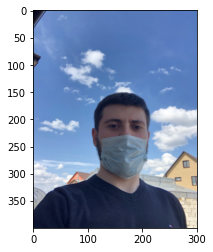

In [4]:
# BCCDデータの読み込み
from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform
testset = VOCDetection(VOC_ROOT, [('BCCD', 'test')], None, VOCAnnotationTransform())

# 10番目を指定
img_id = 10  

# 画像表示
image = testset.pull_image(img_id)
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# 学習済みモデルをファインチューニング


In [6]:
from data import *
from utils.augmentations import SSDAugmentation
from layers.modules import MultiBoxLoss
from ssd import build_ssd
import os
import sys
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torch.utils.data as data
import numpy as np
import argparse
import warnings  
warnings.filterwarnings('ignore')  

# 初期設定
args = {'dataset':'BCCD',   
        'basenet':'vgg16_reducedfc.pth',
        'batch_size':32,
        'resume':'ssd300_mAP_77.43_v2.pth',
        'num_workers':4,  
        'cuda':True,
        'lr':0.0001, 
        'weight_decay':5e-4,
        'gamma':0.5,
        'save_folder':'weights/',
        'EPOCHS':30
       }
cfg = voc

# Tensor作成時のデフォルトにGPU Tensorを設定
if torch.cuda.is_available():
    if args['cuda']:
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
    if not args['cuda']:
        print("WARNING: It looks like you have a CUDA device, but aren't " +
              "using CUDA.\nRun with --cuda for optimal training speed.")
        torch.set_default_tensor_type('torch.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

# ネットワークの定義
ssd_net = build_ssd('train', cfg['min_dim'], cfg['num_classes'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ssd_net.to(device)

# 学習済みパラメータのロード
print('Resuming training, loading {}...'.format(args['resume']))
ssd_net.load_weights(args['save_folder'] + args['resume'])  

# GPU設定
if args['cuda']:
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

# 損失関数の設定
criterion = MultiBoxLoss(cfg['num_classes'], 0.5, True, 0, True, 3, 0.5,
                         False, args['cuda'])

# 最適化手法・学習率のスケジューラーの設定
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=args["gamma"])

# データセットの設定
t_dataset = VOCDetection(root=VOC_ROOT, image_sets=[(args['dataset'], 'train')],
                         transform=SSDAugmentation(cfg['min_dim'], MEANS))
v_dataset = VOCDetection(root=VOC_ROOT, image_sets=[(args['dataset'], 'val')],
                         transform=SSDAugmentation(cfg['min_dim'],MEANS))

# データローダの設定
t_data_loader = data.DataLoader(t_dataset, args['batch_size'],
                              num_workers=args['num_workers'],
                              shuffle=True, collate_fn=detection_collate,
                              pin_memory=True)

v_data_loader = data.DataLoader(v_dataset, args['batch_size'],
                              num_workers=args['num_workers'],
                              shuffle=True, collate_fn=detection_collate,
                              pin_memory=True)

Resuming training, loading ssd300_mAP_77.43_v2.pth...
Loading weights into state dict...
Finished!


In [7]:
print(net)

DataParallel(
  (module): SSD(
    (vgg): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16):

In [8]:
# 学習ループ
train_losses = []
val_losses = []

for epoch in tqdm(range(args["EPOCHS"])):
    print("-"*10, f"Epoch {epoch+1} Start", "-"*10)
    loc_loss = 0
    conf_loss = 0
    net.train()
        
    for data in t_data_loader:    
        # バッチサイズ分のデータをGPUへ
        images, targets = data
        images = images.to(device) 
        targets = [ann.to(device) for ann in targets]
        out = net(images)

        # 逆伝播
        optimizer.zero_grad()
        loss_l, loss_c = criterion((out), targets)
        loss = loss_l + loss_c
        loss.backward()
        optimizer.step()
        loc_loss += loss_l.item()
        conf_loss += loss_c.item()
    
    print(f'Train Loss: {loss.item()}')
    train_losses.append(loss.item())

    # バリデーション
    net.eval()
    valid_loss = []
    for data in v_data_loader:
        images, targets = data
        images = images.to(device) 
        targets = [ann.to(device) for ann in targets]
        out = net(images)
        loss_l, loss_c = criterion(out, targets)
        loss = loss_l + loss_c
        valid_loss.append(loss.item())
    print(f'Validation Loss: {np.mean(valid_loss)}\n')
    val_losses.append(np.mean(valid_loss))

    # スケジューラーを進める
    scheduler.step()

# 学習済みモデルの保存
torch.save(ssd_net.state_dict(),
           args['save_folder'] + '' + args['dataset'] + '.pth')

---------- Epoch 0 Start ----------
Train Loss: 4.156807708740234
Validation Loss: 3.71575220915162

---------- Epoch 1 Start ----------
Train Loss: 3.0661933953813514
Validation Loss: 2.651657279946524

---------- Epoch 2 Start ----------
Train Loss: 2.419395836600422
Validation Loss: 2.701280377242056

---------- Epoch 3 Start ----------
Train Loss: 2.468712576984489
Validation Loss: 2.3772665396867074

---------- Epoch 4 Start ----------
Train Loss: 2.2082360672624146
Validation Loss: 2.7162840263392134

---------- Epoch 5 Start ----------
Train Loss: 2.3781388334171503
Validation Loss: 2.4233630702264213

---------- Epoch 6 Start ----------
Train Loss: 2.1626384848415263
Validation Loss: 2.3221558981732127

---------- Epoch 7 Start ----------
Train Loss: 1.9395770491840683
Validation Loss: 2.4899169974490727

---------- Epoch 8 Start ----------
Train Loss: 2.307267022511316
Validation Loss: 2.352219948418661

---------- Epoch 9 Start ----------
Train Loss: 2.7386641339557927
Valida

Text(0, 0.5, 'Loss')

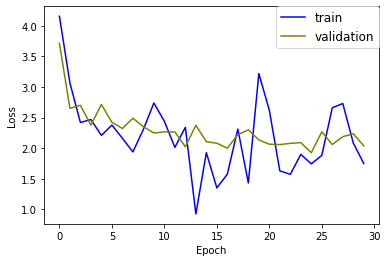

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig = plt.figure()
ax = plt.axes()
ax.plot(range(len(train_losses)), train_losses, color="blue", label="train")
ax.plot(range(len(val_losses)), val_losses, color="olive", label="validation")
_ = plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=12)
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')

# ファインチューニングしたモデルで物体検知（BCCDクラス）


Loading weights into state dict...
Finished!


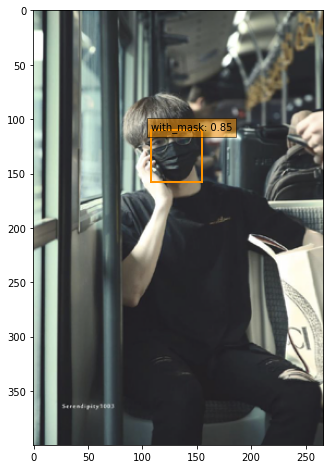

In [10]:
import os
import sys
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
 
from ssd import build_ssd
 
# SSDネットワークの定義とパラメータのロード
net = build_ssd('test', 300, 21)    
net.load_weights('./weights/BCCD.pth')
 
# BCCD_test 読み込み
from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform
from data import BCCD_CLASSES as bccd_labels
testset = VOCDetection(VOC_ROOT, [(args['dataset'], 'test')], None, VOCAnnotationTransform())

# 画像の読み込み
img_id = 42  
image = testset.pull_image(img_id)

# 物体検出
detections = detect(image, bccd_labels)

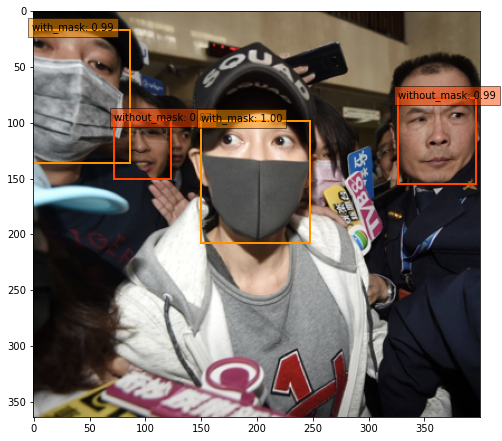

In [11]:
# 画像の読み込み
img_id = 55  
image = testset.pull_image(img_id)

# 物体検出
detections = detect(image, bccd_labels)